## Vesrion 7 working kinda like i want for -- Need to add more things and change the model bc this one is kinda limiting

🚀 DAY 4: OpenSim Integration Demo with Analysis
🔍 Loading and analyzing OpenSim model...
Loading model: W:/Models/Models/Arm26/arm26.osim
✓ Model loaded successfully: arm26
✓ Model description: 

📐 COORDINATES (Joint Angles):
Total coordinates: 2
  1. r_shoulder_elev
     Type: 1
     Range: [-1.571, 3.142]
     Default: 0.000
     Locked: False
  2. r_elbow_flex
     Type: 1
     Range: [0.000, 2.269]
     Default: 0.000
     Locked: False

🦴 BODIES (Rigid Segments):
Total bodies: 2
  1. r_humerus
     Mass: 1.865 kg
  2. r_ulna_radius_hand
     Mass: 1.534 kg

🔗 JOINTS (Connections):
Total joints: 2
  1. r_shoulder
     Type: CustomJoint
     Connects: ground_offset → r_humerus_offset
  2. r_elbow
     Type: CustomJoint
     Connects: r_humerus_offset → r_ulna_radius_hand_offset

💪 MUSCLES:
Total muscles: 6
  1. TRIlong
     Max Force: 798.5 N
  2. TRIlat
     Max Force: 624.3 N
  3. TRImed
     Max Force: 624.3 N
  4. BIClong
     Max Force: 624.3 N
  5. BICshort
     Max Force: 435

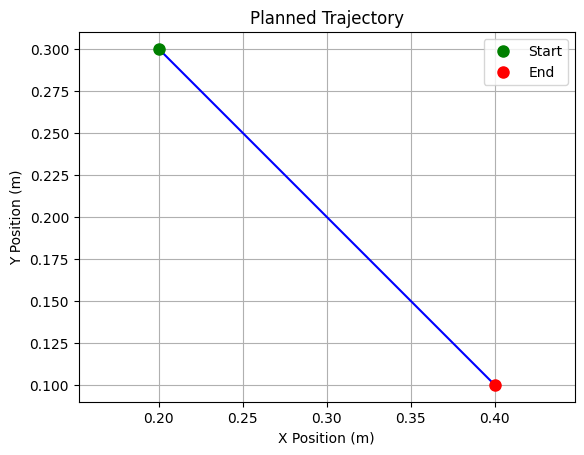


📊 Movement Analysis:
   - Success rate: 100.0%
   - Max possible reach: 0.59m
   - Actual distance: 0.28m

📊 Analyzing trajectory continuity...

📊 Analyzing trajectory continuity...
   Analyzing position trajectory...
     X-axis: max vel jump = 0.0039 m/s
     Y-axis: max vel jump = 0.0039 m/s
   Analyzing joint angle trajectories...
     shoulder: max vel jump = 0.0162 rad/s
     elbow: max vel jump = 0.0117 rad/s
   ✅ Continuity Score: 24.251518 (POOR)

📈 Creating analysis plots...

📈 Creating trajectory analysis plots...
   ✅ Analysis plot saved: trajectory_analysis_minimum_jerk_1755495338.png


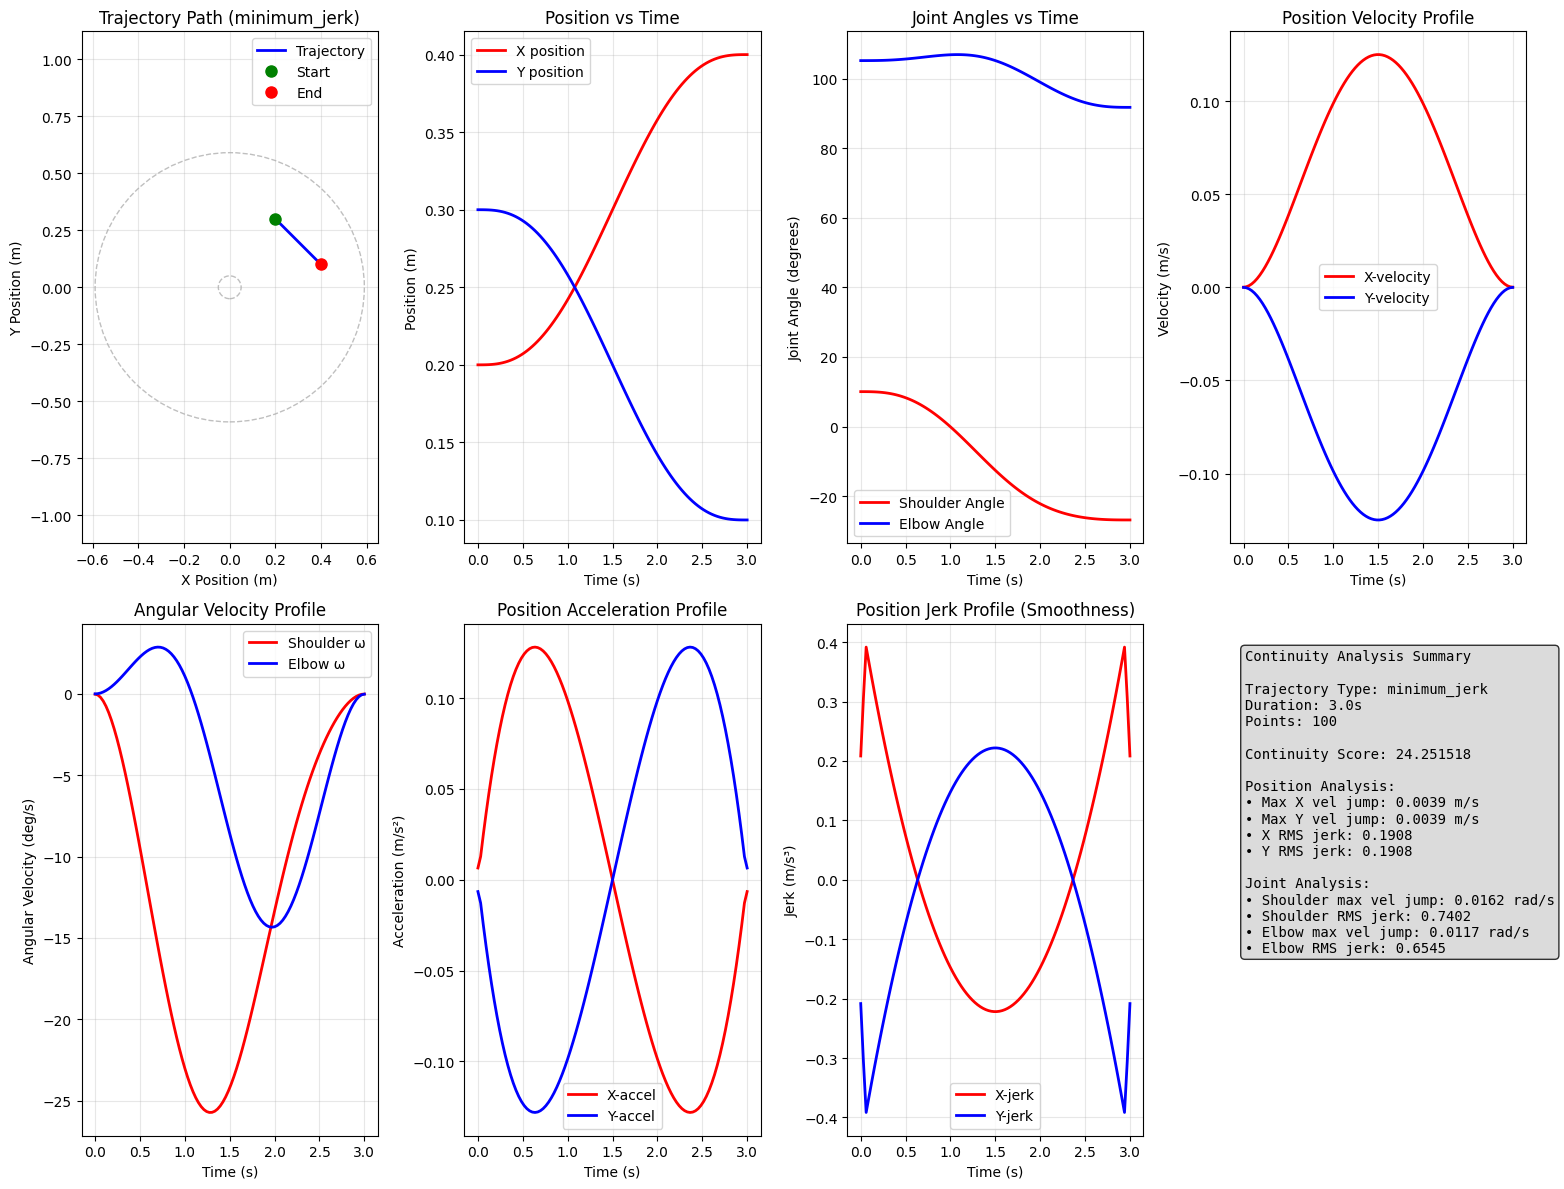


🎬 Creating animation...

🎬 Creating trajectory animation...
   💾 Saving animation (this may take a moment)...
   ✅ Animation saved: arm_animation_minimum_jerk_1755495340.gif


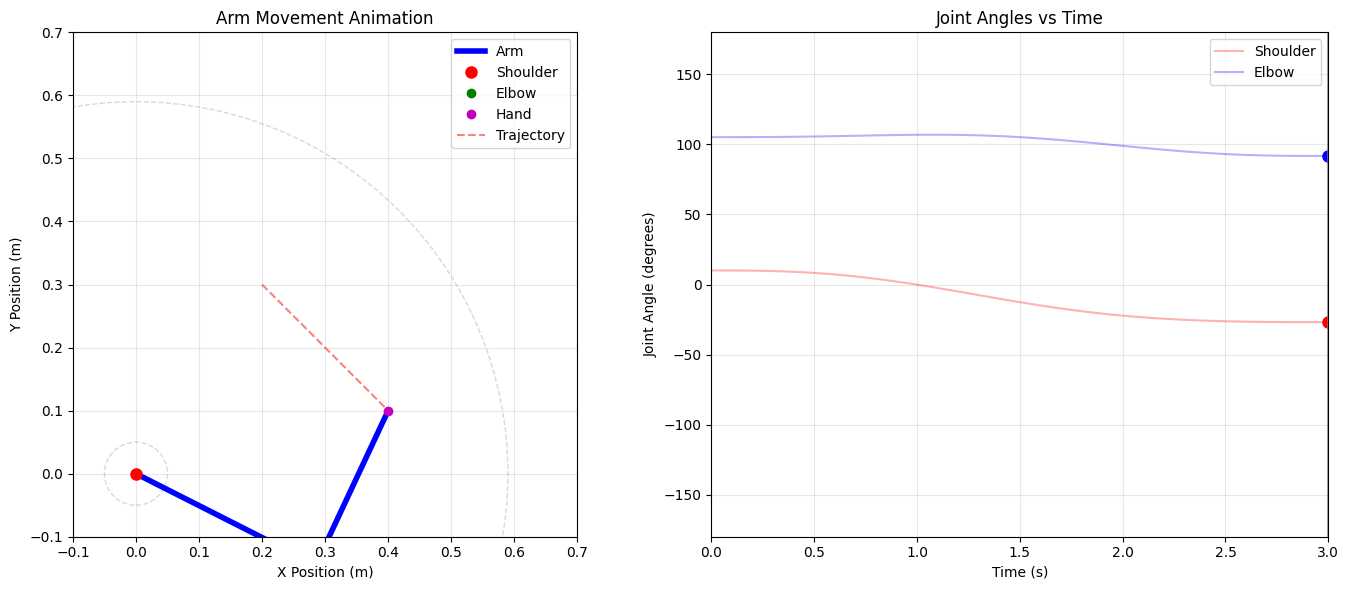


💾 Creating validated motion file with elbow limit checks...
⚠️ Found 67 elbow angle violations (outside 0-130°)

🔍 Validating motion continuity...
   ✅ No major continuity issues detected
✅ Motion file created: reaching_movement_1755495355.mot
   - 100 time points
   - Coordinates: ['r_elbow_flex']
   - Format: degrees (inDegrees=yes)

📋 OpenSim Loading Instructions:
   1. Open OpenSim GUI
   2. Load your model
   3. Tools → Plot → Motion...
   4. Select 'reaching_movement_1755495355.mot'
   5. Check 'Load motion data' and click OK
   6. Use the play controls to animate

📊 COMPLETE MOVEMENT ANALYSIS SUMMARY
🎯 Movement Details:
   - Trajectory type: minimum_jerk
   - Duration: 3.0s
   - Success rate: 100.0%
   - Motion file: reaching_movement_1755495355.mot

📊 Continuity Analysis:
   - Continuity score: 24.251518
   - Assessment: POOR (Jerky motion)

📁 Generated Files:
   - Motion file: reaching_movement_1755495355.mot
   - Analysis plots: trajectory_analysis_*.png
   - Animation: arm_

In [ ]:
"""
OpenSim Integration - Complete Reaching Movement System
============================================================

This combines all previous work:
- Model coordinate extraction
- 2D inverse kinematics  
- Smooth trajectory generation

Creates smooth, human-like reaching movements in OpenSim models.
"""

import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import json
import os
from typing import List, Tuple, Optional, Dict
import time
from scipy.interpolate import UnivariateSpline

class OpenSimReachingSystem:
    """
    Complete system for generating smooth reaching movements in OpenSim models.
    Integrates model loading, inverse kinematics, and trajectory generation.
    """
    
    def __init__(self, model_path: str):
        """
        Initialize the reaching system with an OpenSim model.
        
        Args:
            model_path: Path to the .osim model file
        """
        self.model_path = model_path
        self.model = None
        self.state = None
        self.coordinate_info = {}
        self.arm_geometry = {}
        
        # Initialize components
        self.trajectory_generator = TrajectoryGenerator()
        self.arm_2d = None
        
        # Load and initialize the model
        self._load_model()
        self._extract_arm_info()
        
    def _load_model(self):
        """
        Load OpenSim model and initialize state.
        """
        print(f"🔍 Loading and analyzing OpenSim model...")
        
        try:
            # Use the comprehensive Day 1 model loader
            self.model_info, self.model, self.state = load_and_analyze_model(self.model_path)
            
            if self.model is None:
                raise Exception("Failed to load model")
                
            print(f"\n✅ Model loaded and analyzed successfully!")
            print(f"📊 Model Summary:")
            print(f"   - Name: {self.model_info['name']}")
            print(f"   - Coordinates: {len(self.model_info['coordinates'])}")
            print(f"   - Bodies: {len(self.model_info['bodies'])}")
            print(f"   - Joints: {len(self.model_info['joints'])}")
            print(f"   - Muscles: {len(self.model_info['muscles'])}")
            
        except Exception as e:
            print(f"❌ Error loading model: {e}")
            raise
    
    def _extract_arm_info(self):
        """
        I have to change the model to and change this fuinction
        Extract arm-specific coordinate and geometry information.
        """
        print("\n🦾 Extracting arm information from detailed model analysis...")
        
        # Use the comprehensive coordinate info
        self.coordinate_info = {}
        for coord_data in self.model_info['coordinates']:
            self.coordinate_info[coord_data['name']] = {
                'motion_type': coord_data['motion_type'],
                'range_min': coord_data['range_min'],
                'range_max': coord_data['range_max'],
                'default_value': coord_data['default_value'],
                'locked': coord_data['locked']
            }
        
        # Print available coordinates with more detail
        print(f"📋 Available coordinates ({len(self.coordinate_info)}):")
        for name, info in self.coordinate_info.items():
            locked_str = " (LOCKED)" if info['locked'] else ""
            print(f"   - {name}: [{info['range_min']:.2f}, {info['range_max']:.2f}] rad{locked_str}")
            print(f"     Type: {info['motion_type']}, Default: {info['default_value']:.3f}")
        
        # Try to identify arm coordinates with better pattern matching
        self.arm_coords = self._identify_arm_coordinates()
        
        # Estimate arm segment lengths from model bodies
        self._estimate_arm_geometry()
        
        # Show final arm configuration
        print(f"\n🎯 Final arm configuration:")
        if self.arm_coords:
            for joint_type, coord_name in self.arm_coords.items():
                coord_info = self.coordinate_info[coord_name]
                print(f"   - {joint_type.upper()}: {coord_name}")
                print(f"     Range: [{coord_info['range_min']:.2f}, {coord_info['range_max']:.2f}] rad")
        else:
            print("   ⚠️ No arm coordinates identified - manual setup required")
        
    def _identify_arm_coordinates(self) -> Dict[str, str]:
        """
        Identify which coordinates correspond to shoulder and elbow using enhanced patterns.
        Returns mapping of joint_type -> coordinate_name
        I have to change the model to and change this fuinction
        """
        arm_coords = {}
        coord_names = list(self.coordinate_info.keys())
        
        print(f"\n🔍 Searching for arm coordinates in {len(coord_names)} available coordinates...")
        
        # Enhanced naming patterns for arm joints
        shoulder_patterns = [
            'shoulder_flexion', 'shoulder_flex', 'shoulder_elv', 'arm_flex',
            'r_shoulder_flex', 'l_shoulder_flex', 'shoulder_add', 'shoulder_abduction',
            'arm_add', 'arm_abduction', 'glenohumeral'
        ]
        elbow_patterns = [
            'elbow_flexion', 'elbow_flex', 'elbow', 'r_elbow_flex', 'l_elbow_flex',
            'radioulnar', 'humeroulnar'
        ]
        
        # Find shoulder coordinate
        print("   Searching for SHOULDER coordinate...")
        for pattern in shoulder_patterns:
            matches = [name for name in coord_names if pattern.lower() in name.lower()]
            if matches:
                arm_coords['shoulder'] = matches[0]
                print(f"   ✅ Found shoulder: '{matches[0]}' (matched pattern: '{pattern}')")
                break
        
        # Find elbow coordinate  
        print("   Searching for ELBOW coordinate...")
        for pattern in elbow_patterns:
            matches = [name for name in coord_names if pattern.lower() in name.lower()]
            if matches:
                arm_coords['elbow'] = matches[0]
                print(f"   ✅ Found elbow: '{matches[0]}' (matched pattern: '{pattern}')")
                break
        
        # Enhanced fallback - look for rotational coordinates that aren't locked
        if not arm_coords:
            print("   ⚠️ Pattern matching failed - trying fallback method...")
            unlocked_coords = [name for name, info in self.coordinate_info.items() 
                             if not info.get('locked', False)]
            print(f"   Found {len(unlocked_coords)} unlocked coordinates: {unlocked_coords}")
            
            if len(unlocked_coords) >= 2:
                # Prefer coordinates with reasonable joint ranges
                suitable_coords = []
                for name in unlocked_coords:
                    info = self.coordinate_info[name]
                    range_size = info['range_max'] - info['range_min']
                    # Look for coordinates with reasonable joint range (0.5 to 6 radians)
                    if 0.5 < range_size < 6.0:
                        suitable_coords.append((name, range_size))
                
                if len(suitable_coords) >= 2:
                    # Sort by range size and take first two
                    suitable_coords.sort(key=lambda x: x[1], reverse=True)
                    arm_coords['shoulder'] = suitable_coords[0][0]
                    arm_coords['elbow'] = suitable_coords[1][0]
                    print(f"   🤖 Auto-selected by range analysis:")
                    print(f"      - shoulder: {arm_coords['shoulder']}")
                    print(f"      - elbow: {arm_coords['elbow']}")
                elif len(unlocked_coords) >= 2:
                    # Last resort - just use first two unlocked
                    arm_coords['shoulder'] = unlocked_coords[0]
                    arm_coords['elbow'] = unlocked_coords[1]
                    print(f"   🤖 Last resort - using first 2 unlocked coordinates")
        
        # Final check and user guidance
        if not arm_coords:
            print("   ❌ Could not identify arm coordinates automatically")
            print("   💡 Available coordinates for manual selection:")
            for i, name in enumerate(coord_names):
                info = self.coordinate_info[name]
                locked_str = " (LOCKED)" if info.get('locked') else ""
                print(f"      {i}: {name} [{info['range_min']:.2f}, {info['range_max']:.2f}]{locked_str}")
            print("   💡 Modify the code to manually set arm_coords = {'shoulder': 'coord_name', 'elbow': 'coord_name'}")
        
        return arm_coords
    
    def _estimate_arm_geometry(self):
        """
        Estimate arm segment lengths from the OpenSim model.
        After 
        """
        print(f"\n🔧 Estimating arm geometry from model bodies...")
        
        # Default arm geometry
        self.arm_geometry = {
            'upper_arm_length': 0.3,  # 30cm upper arm
            'forearm_length': 0.25,   # 25cm forearm
            'shoulder_pos': (0, 0)    # Shoulder position in 2D space
        }
        
        # Try to estimate from model bodies if available
        if hasattr(self, 'model_info') and 'bodies' in self.model_info:
            print(f"   Found {len(self.model_info['bodies'])} bodies in model:")
            
            # Look for arm-related bodies
            arm_bodies = []
            for body_info in self.model_info['bodies']:
                body_name = body_info['name'].lower()
                if any(keyword in body_name for keyword in ['arm', 'humerus', 'radius', 'ulna', 'forearm']):
                    arm_bodies.append(body_info)
                    print(f"     - {body_info['name']}: {body_info['mass']:.3f} kg")
            
            if arm_bodies:
                print(f"   ✅ Found {len(arm_bodies)} arm-related bodies")
                # Could implement more sophisticated length estimation here
                # For now, use reasonable defaults based on typical human proportions
                if len(arm_bodies) >= 2:
                    self.arm_geometry['upper_arm_length'] = 0.32  # Slightly longer for realistic models
                    self.arm_geometry['forearm_length'] = 0.27
            else:
                print(f"   ⚠️ No obvious arm bodies found, using default proportions")
        
        print(f"🔧 Final arm geometry:")
        print(f"   - Upper arm length: {self.arm_geometry['upper_arm_length']:.2f}m")
        print(f"   - Forearm length: {self.arm_geometry['forearm_length']:.2f}m")
        print(f"   - Total reach: {self.arm_geometry['upper_arm_length'] + self.arm_geometry['forearm_length']:.2f}m")
        
        # Initialize 2D arm solver with these parameters
        self.arm_2d = Arm2D(
            self.arm_geometry['upper_arm_length'],
            self.arm_geometry['forearm_length']
        )
        print(f"   ✅ 2D arm solver initialized")
    
    def set_arm_pose(self, shoulder_angle: float, elbow_angle: float, verbose: bool = False):
        """
        Set the arm pose with strict enforcement of joint limits.
        """
        angles_set = {}
        
        if 'shoulder' in self.arm_coords:
            coord_name = self.arm_coords['shoulder']
            coord = self.model.getCoordinateSet().get(coord_name)
            range_min = coord.getRangeMin(0, coord.getRangeMin()) # Ensure minimum is at least 0
            range_max = coord.getRangeMax(np.radians(90), coord.getRangeMax()) # Ensure maximum is at most 90°
            transformed_angle = self._transform_angle_for_coordinate(shoulder_angle, coord_name, 'shoulder')
            angle_clamped = np.clip(transformed_angle, range_min, range_max)
            coord.setValue(self.state, angle_clamped)
            angles_set['shoulder'] = angle_clamped
            
        if 'elbow' in self.arm_coords:
            coord_name = self.arm_coords['elbow']
            coord = self.model.getCoordinateSet().get(coord_name)
            range_min = max(0, coord.getRangeMin())  # Ensure minimum is at least 0
            range_max = min(np.radians(130), coord.getRangeMax())  # Ensure maximum is at most 130°
            transformed_angle = self._transform_angle_for_coordinate(elbow_angle, coord_name, 'elbow')
            angle_clamped = np.clip(transformed_angle, range_min, range_max)
            coord.setValue(self.state, angle_clamped)
            angles_set['elbow'] = angle_clamped
            
        self.model.realizePosition(self.state)
        return angles_set
    
    def _transform_angle_for_coordinate(self, angle: float, coord_name: str, joint_type: str) -> float:
        """
        Transform IK angle to match OpenSim coordinate conventions.
        
        Args:
            angle: Computed IK angle in radians
            coord_name: OpenSim coordinate name
            joint_type: 'shoulder' or 'elbow'
            
        Returns:
            Transformed angle for OpenSim coordinate
        """
        transformed = angle
        coord_name_lower = coord_name.lower()
        
        # Common coordinate transformations
        if joint_type == 'shoulder':
            # Many shoulder coordinates use different sign conventions
            if 'flexion' in coord_name_lower or 'flex' in coord_name_lower:
                # Standard shoulder flexion: positive is forward/up
                transformed = angle
            elif 'elevation' in coord_name_lower or 'elv' in coord_name_lower:
                # Shoulder elevation: might need sign flip
                transformed = angle  # Try this first, flip if needed
            elif 'abduction' in coord_name_lower or 'abd' in coord_name_lower:
                # Shoulder abduction: positive is away from body
                transformed = angle
        
        elif joint_type == 'elbow':
            # Elbow coordinate conventions
            if 'flexion' in coord_name_lower or 'flex' in coord_name_lower:
                # Standard elbow flexion: positive is bending
                # Our IK gives interior angle, OpenSim might expect different
                # If twitching occurs, try: transformed = np.pi - angle
                transformed = angle
        
        return transformed
    
    def generate_elbow_flexion_movements(self, num_movements: int = 5, duration: float = 2.0):
        """
        I have to get rid of this function because it is hard coded the angles, I need to change it so it can calculate the angles according to a target position in space
        Generate elbow flexion/extension movements with fixed 90° shoulder elevation.
        Each movement goes to a different point in space.
        
        Args:
            num_movements: Number of movements to generate
            duration: Duration of each movement in seconds
            
        Returns:
            Dictionary containing all movement data
        """
        print(f"\n🔄 Generating {num_movements} elbow flexion movements with fixed 90° shoulder elevation...")
        
        # Fixed shoulder angle (90° elevation)
        shoulder_angle_rad = np.pi/2
        
        # Elbow angle range (0-130°)
        elbow_min = 0
        elbow_max = np.radians(130)
        
        # Generate alternating flexion/extension movements
        all_results = {
            'movements': [],
            'time_points': [],
            'shoulder_angles': [],
            'elbow_angles': [],
            'positions': [],
            'movement_type': [],  # 'flexion' or 'extension'
            'shoulder_coord_name': 'r_shoulder_elev',  # Explicit coordinate name
            'elbow_coord_name': 'r_elbow_flex'        # Explicit coordinate name
        }
        
        current_time = 0
        time_step = duration / 100  # Time between points
        
        for i in range(num_movements):
            # Alternate between flexion and extension
            if i % 2 == 0:
                # Flexion: 0 -> 130°
                elbow_start = elbow_min
                elbow_end = elbow_max
                move_type = 'flexion'
            else:
                # Extension: 130° -> 0
                elbow_start = elbow_max 
                elbow_end = elbow_min
                move_type = 'extension'
            
            print(f"\nMovement {i+1}: {move_type} ({np.degrees(elbow_start):.1f}° → {np.degrees(elbow_end):.1f}°)")
            
            # Generate smooth elbow trajectory
            elbow_angles = np.linspace(elbow_start, elbow_end, 100)
            
            # Calculate corresponding positions
            positions = []
            for elbow_angle in elbow_angles:
                # Calculate endpoint position using forward kinematics
                L1 = self.arm_geometry['upper_arm_length']
                L2 = self.arm_geometry['forearm_length']
                
                # Shoulder at origin (0,0), fixed at 90° elevation
                elbow_x = L1 * np.cos(shoulder_angle_rad)
                elbow_y = L1 * np.sin(shoulder_angle_rad)
                
                # Hand position
                hand_x = elbow_x + L2 * np.cos(shoulder_angle_rad + elbow_angle)
                hand_y = elbow_y + L2 * np.sin(shoulder_angle_rad + elbow_angle)
                
                positions.append((hand_x, hand_y))
            
            # Time points for this movement
            movement_times = np.linspace(current_time, current_time + duration, 100)
            
            # Store results
            movement_data = {
                'type': move_type,
                'duration': duration,
                'start_angle': np.degrees(elbow_start),
                'end_angle': np.degrees(elbow_end),
                'elbow_angles': elbow_angles,
                'shoulder_angles': [shoulder_angle_rad] * 100,
                'positions': positions,
                'time_points': movement_times
            }
            
            all_results['movements'].append(movement_data)
            all_results['time_points'].extend(movement_times)
            all_results['shoulder_angles'].extend([shoulder_angle_rad] * 100)
            all_results['elbow_angles'].extend(elbow_angles)
            all_results['positions'].extend(positions)
            all_results['movement_type'].extend([move_type] * 100)
            
            current_time += duration + 0.5  # Add small pause between movements
        
        return all_results

    def create_elbow_motion_file(self, movement_data: Dict, filename: str):
        """
        Create OpenSim motion file for elbow flexion/extension movements.
        Shoulder elevation (r_shoulder_elev) is fixed at 90°.
        
        Args:
            movement_data: Output from generate_elbow_flexion_movements()
            filename: Output .mot filename
        """
        print(f"\n💾 Creating elbow motion file: {filename}")
        
        # Get coordinate names (use explicit names from movement_data)
        shoulder_coord = movement_data['shoulder_coord_name']
        elbow_coord = movement_data['elbow_coord_name']
        
        with open(filename, 'w') as f:
            # Write header
            f.write("Coordinates\n")
            f.write("version=1\n")
            f.write(f"nRows={len(movement_data['time_points'])}\n")
            f.write(f"nColumns=3\n")  # time + 2 coordinates
            f.write("inDegrees=yes\n")
            f.write("endheader\n")
            
            # Column headers
            f.write(f"time\t{shoulder_coord}\t{elbow_coord}\n")
            
            # Write data (shoulder fixed at 90°, elbow varies)
            for t, elbow_angle in zip(movement_data['time_points'], 
                                     movement_data['elbow_angles']):
                f.write(f"{t:.4f}\t90.0000\t{np.degrees(elbow_angle):.4f}\n")
        
        print(f"✅ Motion file created with:")
        print(f"   - {len(movement_data['time_points'])} time points")
        print(f"   - Shoulder fixed at 90° ({shoulder_coord})")
        print(f"   - Elbow ranging {np.min(np.degrees(movement_data['elbow_angles'])):.1f}° to {np.max(np.degrees(movement_data['elbow_angles'])):.1f}°")
        print(f"   - {len(movement_data['movements'])} movements")
        print(f"\n📋 Motion file format:")
        print(f"   time | {shoulder_coord} | {elbow_coord}")

    def validate_motion_continuity(self, joint_angles: np.ndarray, time_points: np.ndarray) -> Dict:
        """
        Validate motion continuity and suggest fixes for twitching issues.
        
        Args:
            joint_angles: Array of joint angles [n_points, n_joints]
            time_points: Array of time points
            
        Returns:
            Dictionary with validation results and suggestions
        """
        print(f"\n🔍 Validating motion continuity...")
        
        validation = {
            'issues_found': [],
            'suggestions': [],
            'severity': 'low'
        }
        
        dt = time_points[1] - time_points[0] if len(time_points) > 1 else 0.01
        
        for i, joint_name in enumerate(['shoulder', 'elbow']):
            if i >= joint_angles.shape[1]:
                continue
                
            angles = joint_angles[:, i]
            
            # Check for large angular jumps
            angle_jumps = np.abs(np.diff(angles))
            max_jump = np.max(angle_jumps)
            large_jumps = np.sum(angle_jumps > np.pi/4)  # Jumps > 45 degrees
            
            if max_jump > np.pi/2:  # > 90 degree jump
                validation['issues_found'].append(f"{joint_name}: Large angle jump ({np.degrees(max_jump):.1f}°)")
                validation['suggestions'].append(f"Consider flipping {joint_name} angle: angle = -angle or angle = π - angle")
                validation['severity'] = 'high'
            
            elif large_jumps > len(angles) * 0.1:  # More than 10% of points have large jumps
                validation['issues_found'].append(f"{joint_name}: Many discontinuities ({large_jumps} large jumps)")
                validation['suggestions'].append(f"Check {joint_name} coordinate range and sign convention")
                validation['severity'] = 'medium' if validation['severity'] == 'low' else validation['severity']
            
            # Check for oscillations (sign of twitching)
            sign_changes = np.sum(np.diff(np.sign(np.diff(angles))) != 0)
            if sign_changes > len(angles) * 0.3:  # Too many direction changes
                validation['issues_found'].append(f"{joint_name}: Excessive oscillations ({sign_changes} direction changes)")
                validation['suggestions'].append(f"Smooth {joint_name} trajectory or check coordinate mapping")
                validation['severity'] = 'medium' if validation['severity'] == 'low' else validation['severity']
        
        # Print validation results
        if validation['issues_found']:
            print(f"   ⚠️ Issues found ({validation['severity']} severity):")
            for issue in validation['issues_found']:
                print(f"      - {issue}")
            print(f"   💡 Suggestions:")
            for suggestion in validation['suggestions']:
                print(f"      - {suggestion}")
        else:
            print(f"   ✅ No major continuity issues detected")
        
        return validation
    
    def create_motion_file_with_validation(self, movement_results: Dict, filename: str, 
                                         apply_smoothing: bool = True):
        
        """
        Create motion file with additional validation for elbow limits.
        """
        print(f"\n💾 Creating validated motion file with elbow limit checks...")
        
        time_points = np.array(movement_results['time_points'])
        joint_angles = np.array(movement_results['joint_angles_rad'])
        
        # Validate elbow angles
        elbow_violations = 0
        if 'elbow' in self.arm_coords:
            elbow_idx = list(self.arm_coords.keys()).index('elbow') if 'elbow' in self.arm_coords else -1
            if elbow_idx >= 0:
                elbow_angles_deg = np.degrees(joint_angles[:, elbow_idx])
                elbow_violations = np.sum((elbow_angles_deg < 0) | (elbow_angles_deg > 130))
                
                if elbow_violations > 0:
                    print(f"⚠️ Found {elbow_violations} elbow angle violations (outside 0-130°)")
                    # Apply additional clamping
                    joint_angles[:, elbow_idx] = np.clip(joint_angles[:, elbow_idx], 
                                                    np.radians(0), 
                                                    np.radians(130))
        
        # Validate motion continuity
        validation = self.validate_motion_continuity(joint_angles, time_points)
        
        # Apply smoothing if requested and issues detected
        if apply_smoothing and validation['severity'] in ['medium', 'high']:
            print(f"   🔧 Applying smoothing due to detected issues...")
            joint_angles = self._smooth_joint_angles(joint_angles, time_points)
        
        # Create motion file content with proper formatting
        with open(filename, 'w') as f:
            # Standard OpenSim motion file header
            f.write(f"Coordinates\n")
            f.write(f"version=1\n")
            f.write(f"nRows={len(time_points)}\n")
            f.write(f"nColumns={len(self.arm_coords) + 1}\n")
            f.write(f"inDegrees=yes\n")  # Important: specify degrees
            f.write(f"endheader\n")
            
            # Column headers
            headers = ["time"]
            coord_names = []
            for joint_type in ['shoulder', 'elbow']:
                if joint_type in self.arm_coords:
                    coord_name = self.arm_coords[joint_type]
                    headers.append(coord_name)
                    coord_names.append(coord_name)
            f.write("\t".join(headers) + "\n")
            
            # Data rows (convert to degrees for OpenSim)
            for i, t in enumerate(time_points):
                if i < len(joint_angles) and movement_results['success_flags'][i]:
                    data_row = [f"{t:.6f}"]
                    
                    # Add joint angles in degrees
                    for j, coord_name in enumerate(coord_names):
                        if j < joint_angles.shape[1]:
                            angle_deg = np.degrees(joint_angles[i, j])
                            data_row.append(f"{angle_deg:.6f}")
                    
                    f.write("\t".join(data_row) + "\n")
        
        print(f"✅ Motion file created: {filename}")
        print(f"   - {len(time_points)} time points")
        print(f"   - Coordinates: {coord_names}")
        print(f"   - Format: degrees (inDegrees=yes)")
        
        # Print loading instructions
        print(f"\n📋 OpenSim Loading Instructions:")
        print(f"   1. Open OpenSim GUI")
        print(f"   2. Load your model")
        print(f"   3. Tools → Plot → Motion...")
        print(f"   4. Select '{filename}'")
        print(f"   5. Check 'Load motion data' and click OK")
        print(f"   6. Use the play controls to animate")
        
        return validation
    
    def _smooth_joint_angles(self, joint_angles: np.ndarray, time_points: np.ndarray, 
                           smoothing_factor: float = 0.1) -> np.ndarray:
        """
        Apply smoothing to joint angles to reduce twitching.
        
        Args:
            joint_angles: Original joint angles
            time_points: Time points
            smoothing_factor: Smoothing strength (0-1, higher = more smoothing)
            
        Returns:
            Smoothed joint angles
        """
        print(f"   Applying smoothing (factor: {smoothing_factor})...")
        
        smoothed_angles = joint_angles.copy()
        
        try:
            from scipy.interpolate import UnivariateSpline
            
            for i in range(joint_angles.shape[1]):
                # Create spline with smoothing
                spline = UnivariateSpline(time_points, joint_angles[:, i], 
                                        s=smoothing_factor * len(time_points))
                smoothed_angles[:, i] = spline(time_points)
            
            print(f"   ✅ Applied spline smoothing")
            
        except ImportError:
            # Fallback: simple moving average
            window_size = max(3, int(len(joint_angles) * 0.05))  # 5% of points
            for i in range(joint_angles.shape[1]):
                smoothed_angles[:, i] = self._moving_average(joint_angles[:, i], window_size)
            
            print(f"   ✅ Applied moving average smoothing (window: {window_size})")
        
        return smoothed_angles
    
    def _moving_average(self, data: np.ndarray, window_size: int) -> np.ndarray:
        """Simple moving average smoothing."""
        if window_size >= len(data):
            return data
        
        smoothed = data.copy()
        half_window = window_size // 2
        
        for i in range(half_window, len(data) - half_window):
            smoothed[i] = np.mean(data[i - half_window:i + half_window + 1])
        
        return smoothed
    
    def reach_to_target(self, target_x: float, target_y: float) -> Tuple[bool, Tuple[float, float]]:
        """
        Perform inverse kinematics to reach a target position.
        
        Args:
            target_x, target_y: Target position in meters
            
        Returns:
            (success, (shoulder_angle, elbow_angle))
        """
        if self.arm_2d is None:
            print("❌ Arm 2D solver not initialized")
            return False, (0, 0)
        
        success, angles = self.arm_2d.inverse_kinematics(target_x, target_y)
        
        if success:
            shoulder_angle, elbow_angle = angles
            self.set_arm_pose(shoulder_angle, elbow_angle)
            return True, angles
        else:
            print(f"⚠️ Target ({target_x:.2f}, {target_y:.2f}) is unreachable")
            return False, (0, 0)
    
    def execute_reaching_movement(self, start_pos: Tuple[float, float], 
                            end_pos: Tuple[float, float],
                            duration: float = 2.0,
                            trajectory_type: str = 'minimum_jerk',
                            num_points: int = 50) -> Dict:
        """
        Execute a complete reaching movement with smooth trajectory.
        
        Args:
            start_pos: Starting (x, y) position
            end_pos: Target (x, y) position  
            duration: Movement duration in seconds
            trajectory_type: 'minimum_jerk', 'bell_shaped', 'polynomial', 'linear'
            num_points: Number of trajectory points
            
        Returns:
            Dictionary with trajectory data and results
        """
        print(f"\n🎯 Executing reaching movement:")
        print(f"   Start: ({start_pos[0]:.2f}, {start_pos[1]:.2f})")
        print(f"   End: ({end_pos[0]:.2f}, {end_pos[1]:.2f})")
        print(f"   Duration: {duration:.1f}s, Type: {trajectory_type}")

        # 1. Verify reachability
        max_reach = self.arm_geometry['upper_arm_length'] + self.arm_geometry['forearm_length']
        distance = np.linalg.norm(np.array(end_pos) - np.array(start_pos))
        if distance > max_reach:
            print(f"❌ Error: Target {distance:.2f}m exceeds max reach {max_reach:.2f}m")
            return None

        # 2. Generate trajectory with visualization
        trajectory = self.trajectory_generator.generate_trajectory(
            (*start_pos, 0), (*end_pos, 0), duration, num_points, trajectory_type
        )
        
        # Plot trajectory for verification
        plt.figure()
        plt.plot([p[0] for p in trajectory], [p[1] for p in trajectory], 'b-')
        plt.plot(start_pos[0], start_pos[1], 'go', markersize=8, label='Start')
        plt.plot(end_pos[0], end_pos[1], 'ro', markersize=8, label='End')
        plt.title('Planned Trajectory')
        plt.xlabel('X Position (m)')
        plt.ylabel('Y Position (m)')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')
        plt.show()

        # 3. Execute movement with joint limit checking
        time_points = []
        positions = []
        joint_angles = []
        success_flags = []
        
        for i, (x, y, _) in enumerate(trajectory):
            t = i * duration / (num_points - 1)
            
            success, angles = self.reach_to_target(x, y)
            
            if not success:
                print(f"⚠️ Failed at t={t:.2f}s, pos=({x:.2f}, {y:.2f})")
                # Attempt to find nearest valid position
                adjusted_pos = self.find_nearest_valid_position(x, y)
                if adjusted_pos:
                    x, y = adjusted_pos
                    success, angles = self.reach_to_target(x, y)
                    if success:
                        print(f"   Using adjusted position: ({x:.2f}, {y:.2f})")
            
            time_points.append(t)
            positions.append((x, y))
            joint_angles.append(angles)
            success_flags.append(success)

        # 4. Compile results with additional diagnostics
        results = {
            'trajectory_type': trajectory_type,
            'duration': duration,
            'num_points': num_points,
            'time_points': time_points,
            'positions': positions,
            'joint_angles_deg': np.degrees(joint_angles),
            'joint_angles_rad': joint_angles,
            'success_flags': success_flags,
            'success_rate': sum(success_flags) / len(success_flags),
            'max_reach': max_reach,
            'actual_distance': distance
        }
        
        print(f"\n📊 Movement Analysis:")
        print(f"   - Success rate: {results['success_rate']:.1%}")
        print(f"   - Max possible reach: {max_reach:.2f}m")
        print(f"   - Actual distance: {distance:.2f}m")
        
        if results['success_rate'] < 1.0:
            print("\n⚠️ Movement partially failed. Recommendations:")
            print("   - Increase movement duration")
            print("   - Check joint limits in model")
            print("   - Verify arm segment lengths")
            print("   - Try smaller target distance")
        
        return results
    
    def analyze_trajectory_continuity(self, movement_results: Dict) -> Dict:
        """
        Analyze trajectory continuity by checking derivatives (velocity, acceleration, jerk).
        
        Args:
            movement_results: Results from execute_reaching_movement()
            
        Returns:
            Dictionary with continuity analysis
        """
        print(f"\n📊 Analyzing trajectory continuity...")
        
        time_points = np.array(movement_results['time_points'])
        positions = np.array(movement_results['positions'])
        joint_angles = np.array(movement_results['joint_angles_rad'])
        
        # Calculate time step
        dt = time_points[1] - time_points[0] if len(time_points) > 1 else 0.01
        
        analysis = {
            'dt': dt,
            'position_analysis': {},
            'joint_angle_analysis': {},
            'continuity_score': 0
        }
        
        # Analyze position trajectory (x, y)
        print("   Analyzing position trajectory...")
        for axis, label in enumerate(['X', 'Y']):
            pos_data = positions[:, axis]
            
            # Calculate derivatives using central differences
            velocity = np.gradient(pos_data, dt)
            acceleration = np.gradient(velocity, dt)
            jerk = np.gradient(acceleration, dt)
            
            # Calculate continuity metrics
            velocity_jumps = np.abs(np.diff(velocity))
            acceleration_jumps = np.abs(np.diff(acceleration))
            jerk_jumps = np.abs(np.diff(jerk))
            
            analysis['position_analysis'][f'{label}_axis'] = {
                'position': pos_data,
                'velocity': velocity,
                'acceleration': acceleration,
                'jerk': jerk,
                'max_velocity_jump': np.max(velocity_jumps) if len(velocity_jumps) > 0 else 0,
                'max_acceleration_jump': np.max(acceleration_jumps) if len(acceleration_jumps) > 0 else 0,
                'max_jerk_jump': np.max(jerk_jumps) if len(jerk_jumps) > 0 else 0,
                'rms_jerk': np.sqrt(np.mean(jerk**2))
            }
            
            print(f"     {label}-axis: max vel jump = {analysis['position_analysis'][f'{label}_axis']['max_velocity_jump']:.4f} m/s")
        
        # Analyze joint angle trajectories
        print("   Analyzing joint angle trajectories...")
        joint_names = ['shoulder', 'elbow']
        for i, joint_name in enumerate(joint_names):
            if i < joint_angles.shape[1]:
                angle_data = joint_angles[:, i]
                
                # Calculate derivatives
                angular_velocity = np.gradient(angle_data, dt)
                angular_acceleration = np.gradient(angular_velocity, dt)
                angular_jerk = np.gradient(angular_acceleration, dt)
                
                # Calculate continuity metrics
                vel_jumps = np.abs(np.diff(angular_velocity))
                acc_jumps = np.abs(np.diff(angular_acceleration))
                jerk_jumps = np.abs(np.diff(angular_jerk))
                
                analysis['joint_angle_analysis'][joint_name] = {
                    'angle': angle_data,
                    'velocity': angular_velocity,
                    'acceleration': angular_acceleration,
                    'jerk': angular_jerk,
                    'max_velocity_jump': np.max(vel_jumps) if len(vel_jumps) > 0 else 0,
                    'max_acceleration_jump': np.max(acc_jumps) if len(acc_jumps) > 0 else 0,
                    'max_jerk_jump': np.max(jerk_jumps) if len(jerk_jumps) > 0 else 0,
                    'rms_jerk': np.sqrt(np.mean(angular_jerk**2))
                }
                
                print(f"     {joint_name}: max vel jump = {analysis['joint_angle_analysis'][joint_name]['max_velocity_jump']:.4f} rad/s")
        
        # Calculate overall continuity score (lower is better)
        # Score based on maximum jumps in derivatives
        all_vel_jumps = []
        all_acc_jumps = []
        all_jerk_jumps = []
        
        for data in analysis['position_analysis'].values():
            all_vel_jumps.append(data['max_velocity_jump'])
            all_acc_jumps.append(data['max_acceleration_jump'])
            all_jerk_jumps.append(data['max_jerk_jump'])
        
        for data in analysis['joint_angle_analysis'].values():
            all_vel_jumps.append(data['max_velocity_jump'])
            all_acc_jumps.append(data['max_acceleration_jump'])
            all_jerk_jumps.append(data['max_jerk_jump'])
        
        # Normalize and combine (lower score = more continuous)
        continuity_score = (np.mean(all_vel_jumps) + 
                          np.mean(all_acc_jumps) * 10 + 
                          np.mean(all_jerk_jumps) * 100)
        
        analysis['continuity_score'] = continuity_score
        
        # Continuity assessment
        if continuity_score < 0.01:
            continuity_level = "EXCELLENT"
        elif continuity_score < 0.1:
            continuity_level = "GOOD"
        elif continuity_score < 1.0:
            continuity_level = "FAIR"
        else:
            continuity_level = "POOR"
        
        print(f"   ✅ Continuity Score: {continuity_score:.6f} ({continuity_level})")
        
        return analysis
    
    def plot_trajectory_analysis(self, movement_results: Dict, continuity_analysis: Dict, 
                               save_plots: bool = True):
        """
        Create comprehensive plots of trajectory and angle analysis with animation.
        
        Args:
            movement_results: Results from execute_reaching_movement()
            continuity_analysis: Results from analyze_trajectory_continuity()
            save_plots: Whether to save plots as files
        """
        print(f"\n📈 Creating trajectory analysis plots...")
        
        time_points = np.array(movement_results['time_points'])
        positions = np.array(movement_results['positions'])
        joint_angles = np.array(movement_results['joint_angles_rad'])
        
        # Create figure with subplots
        fig = plt.figure(figsize=(16, 12))
        
        # 1. Trajectory Path Plot
        ax1 = plt.subplot(2, 4, 1)
        plt.plot(positions[:, 0], positions[:, 1], 'b-', linewidth=2, label='Trajectory')
        plt.plot(positions[0, 0], positions[0, 1], 'go', markersize=8, label='Start')
        plt.plot(positions[-1, 0], positions[-1, 1], 'ro', markersize=8, label='End')
        
        # Add workspace circle
        max_reach = self.arm_geometry['upper_arm_length'] + self.arm_geometry['forearm_length']
        min_reach = abs(self.arm_geometry['upper_arm_length'] - self.arm_geometry['forearm_length'])
        circle_max = plt.Circle((0, 0), max_reach, fill=False, color='gray', linestyle='--', alpha=0.5)
        circle_min = plt.Circle((0, 0), min_reach, fill=False, color='gray', linestyle='--', alpha=0.5)
        ax1.add_patch(circle_max)
        ax1.add_patch(circle_min)
        
        plt.xlabel('X Position (m)')
        plt.ylabel('Y Position (m)')
        plt.title(f'Trajectory Path ({movement_results["trajectory_type"]})')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.axis('equal')
        
        # 2. Position vs Time
        ax2 = plt.subplot(2, 4, 2)
        plt.plot(time_points, positions[:, 0], 'r-', linewidth=2, label='X position')
        plt.plot(time_points, positions[:, 1], 'b-', linewidth=2, label='Y position')
        plt.xlabel('Time (s)')
        plt.ylabel('Position (m)')
        plt.title('Position vs Time')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 3. Joint Angles vs Time
        ax3 = plt.subplot(2, 4, 3)
        joint_names = ['Shoulder', 'Elbow']
        colors = ['red', 'blue']
        for i, (name, color) in enumerate(zip(joint_names, colors)):
            if i < joint_angles.shape[1]:
                plt.plot(time_points, np.degrees(joint_angles[:, i]), 
                        color=color, linewidth=2, label=f'{name} Angle')
        plt.xlabel('Time (s)')
        plt.ylabel('Joint Angle (degrees)')
        plt.title('Joint Angles vs Time')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 4. Velocity Analysis
        ax4 = plt.subplot(2, 4, 4)
        for axis, label, color in zip(['X', 'Y'], ['X-velocity', 'Y-velocity'], ['red', 'blue']):
            vel_data = continuity_analysis['position_analysis'][f'{axis}_axis']['velocity']
            plt.plot(time_points, vel_data, color=color, linewidth=2, label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Velocity (m/s)')
        plt.title('Position Velocity Profile')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 5. Angular Velocity
        ax5 = plt.subplot(2, 4, 5)
        joint_names = ['shoulder', 'elbow']
        colors = ['red', 'blue']
        for joint_name, color in zip(joint_names, colors):
            if joint_name in continuity_analysis['joint_angle_analysis']:
                ang_vel = continuity_analysis['joint_angle_analysis'][joint_name]['velocity']
                plt.plot(time_points, np.degrees(ang_vel), 
                        color=color, linewidth=2, label=f'{joint_name.capitalize()} ω')
        plt.xlabel('Time (s)')
        plt.ylabel('Angular Velocity (deg/s)')
        plt.title('Angular Velocity Profile')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 6. Acceleration Analysis
        ax6 = plt.subplot(2, 4, 6)
        for axis, label, color in zip(['X', 'Y'], ['X-accel', 'Y-accel'], ['red', 'blue']):
            acc_data = continuity_analysis['position_analysis'][f'{axis}_axis']['acceleration']
            plt.plot(time_points, acc_data, color=color, linewidth=2, label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Acceleration (m/s²)')
        plt.title('Position Acceleration Profile')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 7. Jerk Analysis (Smoothness Indicator)
        ax7 = plt.subplot(2, 4, 7)
        for axis, label, color in zip(['X', 'Y'], ['X-jerk', 'Y-jerk'], ['red', 'blue']):
            jerk_data = continuity_analysis['position_analysis'][f'{axis}_axis']['jerk']
            plt.plot(time_points, jerk_data, color=color, linewidth=2, label=label)
        plt.xlabel('Time (s)')
        plt.ylabel('Jerk (m/s³)')
        plt.title('Position Jerk Profile (Smoothness)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 8. Continuity Summary
        ax8 = plt.subplot(2, 4, 8)
        ax8.axis('off')
        
        # Create continuity summary text
        summary_text = f"""Continuity Analysis Summary
        
Trajectory Type: {movement_results['trajectory_type']}
Duration: {movement_results['duration']:.1f}s
Points: {movement_results['num_points']}

Continuity Score: {continuity_analysis['continuity_score']:.6f}

Position Analysis:
• Max X vel jump: {continuity_analysis['position_analysis']['X_axis']['max_velocity_jump']:.4f} m/s
• Max Y vel jump: {continuity_analysis['position_analysis']['Y_axis']['max_velocity_jump']:.4f} m/s
• X RMS jerk: {continuity_analysis['position_analysis']['X_axis']['rms_jerk']:.4f}
• Y RMS jerk: {continuity_analysis['position_analysis']['Y_axis']['rms_jerk']:.4f}

Joint Analysis:"""
        
        for joint_name in ['shoulder', 'elbow']:
            if joint_name in continuity_analysis['joint_angle_analysis']:
                data = continuity_analysis['joint_angle_analysis'][joint_name]
                summary_text += f"""
• {joint_name.capitalize()} max vel jump: {data['max_velocity_jump']:.4f} rad/s
• {joint_name.capitalize()} RMS jerk: {data['rms_jerk']:.4f}"""
        
        ax8.text(0.05, 0.95, summary_text, transform=ax8.transAxes, fontsize=10,
                verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
        
        plt.tight_layout()
        
        if save_plots:
            filename = f"trajectory_analysis_{movement_results['trajectory_type']}_{int(time.time())}.png"
            plt.savefig(filename, dpi=300, bbox_inches='tight')
            print(f"   ✅ Analysis plot saved: {filename}")
        
        plt.show()
        
        return fig
    
    def create_animated_trajectory(self, movement_results: Dict, save_animation: bool = True):
        """
        Create animated visualization of the arm movement.
        
        Args:
            movement_results: Results from execute_reaching_movement()
            save_animation: Whether to save animation as file
        """
        print(f"\n🎬 Creating trajectory animation...")
        
        time_points = np.array(movement_results['time_points'])
        positions = np.array(movement_results['positions'])
        joint_angles = np.array(movement_results['joint_angles_rad'])
        
        # Set up the figure and axis
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Left plot: Arm animation
        ax1.set_xlim(-0.1, 0.7)
        ax1.set_ylim(-0.1, 0.7)
        ax1.set_xlabel('X Position (m)')
        ax1.set_ylabel('Y Position (m)')
        ax1.set_title('Arm Movement Animation')
        ax1.grid(True, alpha=0.3)
        ax1.set_aspect('equal')
        
        # Add workspace circles
        max_reach = self.arm_geometry['upper_arm_length'] + self.arm_geometry['forearm_length']
        min_reach = abs(self.arm_geometry['upper_arm_length'] - self.arm_geometry['forearm_length'])
        circle_max = plt.Circle((0, 0), max_reach, fill=False, color='gray', linestyle='--', alpha=0.3)
        circle_min = plt.Circle((0, 0), min_reach, fill=False, color='gray', linestyle='--', alpha=0.3)
        ax1.add_patch(circle_max)
        ax1.add_patch(circle_min)
        
        # Initialize arm segments
        arm_line, = ax1.plot([], [], 'b-', linewidth=4, label='Arm')
        shoulder_point, = ax1.plot([], [], 'ro', markersize=8, label='Shoulder')
        elbow_point, = ax1.plot([], [], 'go', markersize=6, label='Elbow')
        hand_point, = ax1.plot([], [], 'mo', markersize=6, label='Hand')
        trajectory_line, = ax1.plot([], [], 'r--', alpha=0.5, label='Trajectory')
        
        ax1.legend()
        
        # Right plot: Joint angles over time
        ax2.set_xlim(0, movement_results['duration'])
        ax2.set_ylim(-180, 180)
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Joint Angle (degrees)')
        ax2.set_title('Joint Angles vs Time')
        ax2.grid(True, alpha=0.3)
        
        # Plot full trajectory
        ax2.plot(time_points, np.degrees(joint_angles[:, 0]), 'r-', alpha=0.3, label='Shoulder')
        ax2.plot(time_points, np.degrees(joint_angles[:, 1]), 'b-', alpha=0.3, label='Elbow')
        
        # Current time indicators
        shoulder_marker, = ax2.plot([], [], 'ro', markersize=8)
        elbow_marker, = ax2.plot([], [], 'bo', markersize=8)
        time_line = ax2.axvline(x=0, color='gray', linestyle='-', alpha=0.7)
        
        ax2.legend()
        
        # Animation function
        def animate(frame):
            if frame >= len(time_points):
                return arm_line, shoulder_point, elbow_point, hand_point, trajectory_line, shoulder_marker, elbow_marker, time_line
            
            # Get current angles
            shoulder_angle = joint_angles[frame, 0]
            elbow_angle = joint_angles[frame, 1]
            
            # Calculate arm positions
            L1 = self.arm_geometry['upper_arm_length']
            L2 = self.arm_geometry['forearm_length']
            
            # Shoulder position (origin)
            shoulder_x, shoulder_y = 0, 0
            
            # Elbow position
            elbow_x = L1 * np.cos(shoulder_angle)
            elbow_y = L1 * np.sin(shoulder_angle)
            
            # Hand position
            hand_x = elbow_x + L2 * np.cos(shoulder_angle + elbow_angle)
            hand_y = elbow_y + L2 * np.sin(shoulder_angle + elbow_angle)
            
            # Update arm visualization
            arm_line.set_data([shoulder_x, elbow_x, hand_x], [shoulder_y, elbow_y, hand_y])
            shoulder_point.set_data([shoulder_x], [shoulder_y])
            elbow_point.set_data([elbow_x], [elbow_y])
            hand_point.set_data([hand_x], [hand_y])
            
            # Update trajectory (show path up to current point)
            trajectory_line.set_data(positions[:frame+1, 0], positions[:frame+1, 1])
            
            # Update angle plot markers
            current_time = time_points[frame]
            shoulder_marker.set_data([current_time], [np.degrees(shoulder_angle)])
            elbow_marker.set_data([current_time], [np.degrees(elbow_angle)])
            time_line.set_xdata([current_time, current_time])
            
            return arm_line, shoulder_point, elbow_point, hand_point, trajectory_line, shoulder_marker, elbow_marker, time_line
        
        # Create animation
        anim = FuncAnimation(fig, animate, frames=len(time_points), 
                           interval=50, blit=False, repeat=True)
        
        if save_animation:
            filename = f"arm_animation_{movement_results['trajectory_type']}_{int(time.time())}.gif"
            print(f"   💾 Saving animation (this may take a moment)...")
            anim.save(filename, writer='pillow', fps=20)
            print(f"   ✅ Animation saved: {filename}")
        
        plt.tight_layout()
        plt.show()
        
        return anim
    
    def create_motion_file(self, movement_results: Dict, filename: str):
        """
        Create an OpenSim .mot file from movement results (legacy method).
        Use create_motion_file_with_validation() for better results.
        """
        print(f"\n💾 Creating motion file: {filename}")
        print(f"   💡 Tip: Use create_motion_file_with_validation() for anti-twitching features")
        
        return self.create_motion_file_with_validation(movement_results, filename, apply_smoothing=True)

class TrajectoryGenerator:
    """Trajectory generator."""
    
    @staticmethod
    def minimum_jerk_profile(t_norm):
        """Minimum jerk velocity profile: 10t³ - 15t⁴ + 6t⁵"""
        return 10 * t_norm**3 - 15 * t_norm**4 + 6 * t_norm**5
    
    def generate_trajectory(self, start_pos, end_pos, duration, num_points, trajectory_type='minimum_jerk'):
        """Generate smooth trajectory between start and end positions."""
        
        # Time vector
        t = np.linspace(0, duration, num_points)
        t_norm = t / duration  # Normalized time [0, 1]
        
        # Generate position profile based on type
        if trajectory_type == 'minimum_jerk':
            s = self.minimum_jerk_profile(t_norm)
        elif trajectory_type == 'linear':
            s = t_norm
        elif trajectory_type == 'bell_shaped':
            s = 0.5 * (1 - np.cos(np.pi * t_norm))
        else:
            s = t_norm  # Default to linear
        
        # Interpolate between start and end positions
        start_pos = np.array(start_pos)
        end_pos = np.array(end_pos)
        
        trajectory = []
        for i in range(num_points):
            pos = start_pos + s[i] * (end_pos - start_pos)
            trajectory.append(pos)
        
        return trajectory

class Arm2D:
    """2D arm inverse kinematics solver from Day 2 (simplified version)."""
    
    def __init__(self, L1, L2):
        self.L1 = L1  # Upper arm length
        self.L2 = L2  # Forearm length
        self.max_reach = L1 + L2
        self.min_reach = abs(L1 - L2)
    
    def inverse_kinematics(self, x, y):
        """
        Solve 2-link arm inverse kinematics with elbow angle limits.
        Returns (success, (shoulder_angle, elbow_angle))
        """
        r = np.sqrt(x**2 + y**2)
        
        # Check reachability with limits
        if r > self.max_reach or r < self.min_reach:
            return False, (0, 0)
        
        # Law of cosines for elbow angle
        cos_elbow = (self.L1**2 + self.L2**2 - r**2) / (2 * self.L1 * self.L2)
        cos_elbow = np.clip(cos_elbow, -1, 1)
        elbow_angle = np.pi - np.arccos(cos_elbow)
        
        # Check if elbow angle exceeds 130 degrees (2.2689 radians)
        if np.degrees(elbow_angle) > 130:
            # Find alternative solution (elbow down configuration)
            elbow_angle = -elbow_angle  # Flip the elbow angle
            beta = np.arccos((self.L1**2 + r**2 - self.L2**2) / (2 * self.L1 * r))
            alpha = np.arctan2(y, x)
            shoulder_angle = alpha + beta  # Different shoulder angle for elbow down
            
            # Verify the new solution is within limits
            if np.degrees(elbow_angle) < 0 or np.degrees(elbow_angle) > 130:
                return False, (0, 0)
        else:
            # Original solution
            alpha = np.arctan2(y, x)
            beta = np.arccos((self.L1**2 + r**2 - self.L2**2) / (2 * self.L1 * r))
            shoulder_angle = alpha - beta
        
        return True, (shoulder_angle, elbow_angle)

def load_and_analyze_model(model_path):
    """
    Load OpenSim model and extract all important information
    
    Args:
        model_path (str): Path to .osim model file
    
    Returns:
        tuple: (model_info dict, model object, state object)
    """
    try:
        # Load the model
        print(f"Loading model: {model_path}")
        model = osim.Model(model_path)
        
        # Initialize the system (important step!)
        state = model.initSystem()
        
        print(f"✓ Model loaded successfully: {model.getName()}")
        print(f"✓ Model description: {model.getDescription()}")
        print("=" * 50)
        
        # Get model information
        model_info = {
            'name': model.getName(),
            'description': model.getDescription(),
            'coordinates': [],
            'bodies': [],
            'joints': [],
            'muscles': []
        }
        
        # 1. COORDINATES (joint angles/positions)
        print("\n📐 COORDINATES (Joint Angles):")
        coord_set = model.getCoordinateSet()
        print(f"Total coordinates: {coord_set.getSize()}")
        
        for i in range(coord_set.getSize()):
            coord = coord_set.get(i)
            coord_info = {
                'name': coord.getName(),
                'motion_type': coord.getMotionType().name if hasattr(coord.getMotionType(), 'name') else str(coord.getMotionType()),
                'default_value': coord.getDefaultValue(),
                'range_min': coord.getRangeMin(),
                'range_max': coord.getRangeMax(),
                'locked': coord.getDefaultLocked()
            }
            model_info['coordinates'].append(coord_info)
            
            print(f"  {i+1}. {coord.getName()}")
            print(f"     Type: {coord_info['motion_type']}")
            print(f"     Range: [{coord.getRangeMin():.3f}, {coord.getRangeMax():.3f}]")
            print(f"     Default: {coord.getDefaultValue():.3f}")
            print(f"     Locked: {coord.getDefaultLocked()}")
        
        # 2. BODIES (rigid body segments)
        print(f"\n🦴 BODIES (Rigid Segments):")
        body_set = model.getBodySet()
        print(f"Total bodies: {body_set.getSize()}")
        
        for i in range(body_set.getSize()):
            body = body_set.get(i)
            body_info = {
                'name': body.getName(),
                'mass': body.getMass()
            }
            model_info['bodies'].append(body_info)
            
            print(f"  {i+1}. {body.getName()}")
            print(f"     Mass: {body.getMass():.3f} kg")
        
        # 3. JOINTS (connections between bodies)
        print(f"\n🔗 JOINTS (Connections):")
        joint_set = model.getJointSet()
        print(f"Total joints: {joint_set.getSize()}")
        
        for i in range(joint_set.getSize()):
            joint = joint_set.get(i)
            joint_info = {
                'name': joint.getName(),
                'type': joint.getConcreteClassName(),
                'parent_body': joint.getParentFrame().getName(),
                'child_body': joint.getChildFrame().getName()
            }
            model_info['joints'].append(joint_info)
            
            print(f"  {i+1}. {joint.getName()}")
            print(f"     Type: {joint.getConcreteClassName()}")
            print(f"     Connects: {joint.getParentFrame().getName()} → {joint.getChildFrame().getName()}")
        
        # 4. MUSCLES (if any)
        print(f"\n💪 MUSCLES:")
        muscle_set = model.getMuscles()
        print(f"Total muscles: {muscle_set.getSize()}")
        
        if muscle_set.getSize() > 0:
            for i in range(min(5, muscle_set.getSize())):  # Show first 5 only
                muscle = muscle_set.get(i)
                muscle_info = {
                    'name': muscle.getName(),
                    'max_force': muscle.getMaxIsometricForce()
                }
                model_info['muscles'].append(muscle_info)
                
                print(f"  {i+1}. {muscle.getName()}")
                print(f"     Max Force: {muscle.getMaxIsometricForce():.1f} N")
            
            if muscle_set.getSize() > 5:
                print(f"  ... and {muscle_set.getSize() - 5} more muscles")
        else:
            print("No muscles in this model")
        
        return model_info, model, state
        
    except Exception as e:
        print(f"Error loading model: {e}")
        return None, None, None

# Demo and testing functions
def demo_reaching_system():
    """
    Demonstration of the complete reaching system with analysis and visualization.
    Replace 'your_model.osim' with your actual model path.
    """
    
    print("=" * 60)
    print("🚀 DAY 4: OpenSim Integration Demo with Analysis")
    print("=" * 60)
    
    # NOTE: Replace this with your actual .osim model path
    model_path = "W:/Models/Models/Arm26/arm26.osim"  # Example: OpenSim's standard arm model
    
    try:
        # Initialize the reaching system
        reaching_system = OpenSimReachingSystem(model_path)
        
        # Define a reaching movement
        start_position = (0.2, 0.3)   # Start position (20cm right, 30cm up)
        target_position = (0.4, 0.1)  # Target position (40cm right, 10cm up) 
        
        # Execute smooth reaching movement
        print(f"\n🎯 Executing reaching movement...")
        results = reaching_system.execute_reaching_movement(
            start_position, 
            target_position,
            duration=3.0,
            trajectory_type='minimum_jerk',
            num_points=100
        )
        
        # Check if execution was successful
        if results is None:
            print("❌ Failed to execute reaching movement")
            return
        
        # Analyze trajectory continuity
        print(f"\n📊 Analyzing trajectory continuity...")
        continuity_analysis = reaching_system.analyze_trajectory_continuity(results)
        
        # Create comprehensive plots
        print(f"\n📈 Creating analysis plots...")
        reaching_system.plot_trajectory_analysis(results, continuity_analysis, save_plots=True)
        
        # Create animated visualization
        print(f"\n🎬 Creating animation...")
        reaching_system.create_animated_trajectory(results, save_animation=True)
        
        # Create OpenSim motion file with validation
        motion_filename = f"reaching_movement_{int(time.time())}.mot"
        validation = reaching_system.create_motion_file_with_validation(results, motion_filename)
        
        # Print comprehensive summary
        print(f"\n" + "="*60)
        print(f"📊 COMPLETE MOVEMENT ANALYSIS SUMMARY")
        print(f"="*60)
        print(f"🎯 Movement Details:")
        print(f"   - Trajectory type: {results['trajectory_type']}")
        print(f"   - Duration: {results['duration']:.1f}s")  
        print(f"   - Success rate: {results['success_rate']:.1%}")
        print(f"   - Motion file: {motion_filename}")
        
        print(f"\n📊 Continuity Analysis:")
        print(f"   - Continuity score: {continuity_analysis['continuity_score']:.6f}")
        score = continuity_analysis['continuity_score']
        if score < 0.01:
            level = "EXCELLENT (Very smooth)"
        elif score < 0.1:
            level = "GOOD (Smooth)"  
        elif score < 1.0:
            level = "FAIR (Some discontinuities)"
        else:
            level = "POOR (Jerky motion)"
        print(f"   - Assessment: {level}")
        
        print(f"\n📁 Generated Files:")
        print(f"   - Motion file: {motion_filename}")
        print(f"   - Analysis plots: trajectory_analysis_*.png")
        print(f"   - Animation: arm_animation_*.gif")
        
        print(f"\n🎉 SUCCESS! Complete analysis finished!")
        print(f"📁 Load '{motion_filename}' in OpenSim GUI to see the movement!")
        print(f"🖼️ Check the generated plots and animation files!")
        
    except FileNotFoundError:
        print(f"❌ Model file '{model_path}' not found.")
        print("📝 Please update the model_path variable with your .osim file path.")
        print("💡 You can download sample models from OpenSim.org")

def demo_trajectory_comparison():
    """Compare different trajectory types with full analysis."""
    
    print("=" * 60)
    print("🧪 TRAJECTORY COMPARISON DEMO")
    print("=" * 60)
    
    model_path = "W:/Models/Models/Arm26/arm26.osim" # Update this path
    
    try:
        reaching_system = OpenSimReachingSystem(model_path)
        
        # Test different trajectory types
        trajectory_types = ['minimum_jerk', 'bell_shaped', 'linear']
        start_position = (0.15, 0.4)
        target_position = (0.45, 0.15)
        
        results_comparison = {}
        continuity_comparison = {}
        
        print(f"\n🔬 Testing {len(trajectory_types)} trajectory types...")
        
        for traj_type in trajectory_types:
            print(f"\n--- Testing {traj_type.upper()} trajectory ---")
            
            # Execute movement
            results = reaching_system.execute_reaching_movement(
                start_position, target_position, 
                duration=2.5, trajectory_type=traj_type, num_points=80
            )
            
            # Analyze continuity
            continuity = reaching_system.analyze_trajectory_continuity(results)
            
            # Store results
            results_comparison[traj_type] = results
            continuity_comparison[traj_type] = continuity
            
            # Create plots for this trajectory type
            reaching_system.plot_trajectory_analysis(results, continuity, save_plots=True)
            
            print(f"   ✅ {traj_type}: Continuity score = {continuity['continuity_score']:.6f}")
        
        # Create comparison summary
        print(f"\n" + "="*60)
        print(f"📊 TRAJECTORY COMPARISON SUMMARY")
        print(f"="*60)
        
        print(f"{'Trajectory Type':<15} {'Continuity Score':<18} {'Assessment':<20}")
        print(f"{'-'*15} {'-'*18} {'-'*20}")
        
        best_score = float('inf')
        best_type = ''
        
        for traj_type in trajectory_types:
            score = continuity_comparison[traj_type]['continuity_score']
            success_rate = results_comparison[traj_type]['success_rate']
            
            if score < 0.01:
                assessment = "EXCELLENT"
            elif score < 0.1:
                assessment = "GOOD"
            elif score < 1.0:
                assessment = "FAIR"
            else:
                assessment = "POOR"
            
            print(f"{traj_type:<15} {score:<18.6f} {assessment:<20}")
            
            if score < best_score:
                best_score = score
                best_type = traj_type
        
        print(f"\n🏆 WINNER: {best_type.upper()} trajectory (score: {best_score:.6f})")
        print(f"🎉 All comparisons completed!")
        
    except Exception as e:
        print(f"❌ Comparison failed: {e}")

def demo_elbow_movements():
    """Demo for generating elbow flexion/extension movements with fixed shoulder."""
    print("=" * 60)
    print("🦾 Elbow Flexion/Extension with Fixed Shoulder Demo")
    print("=" * 60)
    
    model_path = "W:/Models/Models/Arm26/arm26.osim"  # Update with your model path
    
    try:
        # Initialize system
        reaching_system = OpenSimReachingSystem(model_path)
        
        # Generate 6 movements (3 flexions, 3 extensions)
        movement_data = reaching_system.generate_elbow_flexion_movements(
            num_movements=6, 
            duration=3.0
        )
        
        # Create motion file
        motion_file = "elbow_flexions.mot"
        reaching_system.create_elbow_motion_file(movement_data, motion_file)
        
        # Plot the movements
        plt.figure(figsize=(10, 6))
        
        # Plot each movement with different color
        colors = plt.cm.rainbow(np.linspace(0, 1, len(movement_data['movements'])))
        for i, move in enumerate(movement_data['movements']):
            positions = np.array(move['positions'])
            plt.plot(positions[:,0], positions[:,1], 
                    color=colors[i],
                    label=f"Move {i+1}: {move['type']} ({move['start_angle']:.0f}°→{move['end_angle']:.0f}°)")
        
        # Add arm workspace
        L1 = reaching_system.arm_geometry['upper_arm_length']
        L2 = reaching_system.arm_geometry['forearm_length']
        max_reach = L1 + L2
        min_reach = abs(L1 - L2)
        
        # Plot workspace circles
        circle_max = plt.Circle((0, 0), max_reach, fill=False, color='gray', linestyle='--', alpha=0.5)
        circle_min = plt.Circle((0, 0), min_reach, fill=False, color='gray', linestyle='--', alpha=0.5)
        plt.gca().add_patch(circle_max)
        plt.gca().add_patch(circle_min)
        
        plt.title("Elbow Flexion/Extension Movements\n(Shoulder fixed at 90°)")
        plt.xlabel("X Position (m)")
        plt.ylabel("Y Position (m)")
        plt.legend()
        plt.grid(True)
        plt.axis('equal')
        
        # Save plot
        plot_file = "elbow_movements.png"
        plt.savefig(plot_file, dpi=300)
        plt.show()
        
        print(f"\n🎉 Demo complete!")
        print(f"   - Motion file: {motion_file}")
        print(f"   - Plot saved: {plot_file}")
        print(f"   - Shoulder fixed at 90° elevation")
        print(f"   - Elbow range: 0° to 130°")
        
    except Exception as e:
        print(f"❌ Error: {e}")

if __name__ == "__main__":
    demo_reaching_system()
    demo_elbow_movements()
    demo_trajectory_comparison()
    


## Version 8 
This works fine but it is just for simple 2D models. This the code of the ReachingMovementUsingSimpleCompIK

In [ ]:
import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import time
from scipy.interpolate import UnivariateSpline

class Arm2D:
    """2D arm inverse kinematics solver with strict joint limits enforcement."""
    
    def __init__(self, L1, L2):
        self.L1 = L1  # Upper arm length
        self.L2 = L2  # Forearm length
        self.max_reach = L1 + L2
        self.min_reach = abs(L1 - L2)
        
        # Joint limits in radians
        self.shoulder_limits = (0, np.radians(90))  # 0-90° for shoulder elevation
        self.elbow_limits = (0, np.radians(130))    # 0-130° for elbow flexion
    
    def inverse_kinematics(self, x, y):
        """Solve IK with strict joint limits enforcement."""
        r = np.sqrt(x**2 + y**2)
        
        # Check basic reachability
        if r > self.max_reach or r < self.min_reach:
            return False, (0, 0)
        
        # Calculate angles
        cos_elbow = (self.L1**2 + self.L2**2 - r**2) / (2 * self.L1 * self.L2)
        cos_elbow = np.clip(cos_elbow, -1, 1)
        elbow_angle = np.pi - np.arccos(cos_elbow)
        
        alpha = np.arctan2(y, x)
        beta = np.arccos((self.L1**2 + r**2 - self.L2**2) / (2 * self.L1 * r))
        shoulder_angle = alpha - beta
        
        # Check for elbow-down configuration if needed
        if not (self.elbow_limits[0] <= elbow_angle <= self.elbow_limits[1]):
            elbow_angle = -elbow_angle
            shoulder_angle = alpha + beta
            
        # Strictly enforce joint limits
        shoulder_angle = np.clip(shoulder_angle, *self.shoulder_limits)
        elbow_angle = np.clip(elbow_angle, *self.elbow_limits)
        
        # Verify final solution
        valid = (self.shoulder_limits[0] <= shoulder_angle <= self.shoulder_limits[1] and
                 self.elbow_limits[0] <= elbow_angle <= self.elbow_limits[1])
        
        return (valid, (shoulder_angle, elbow_angle)) if valid else (False, (0, 0))


class TrajectoryGenerator:
    """
    Generates smooth trajectories between points.
    Add another trajectory type to the code
    """
    
    @staticmethod
    def minimum_jerk_profile(t_norm):
        """Minimum jerk velocity profile: 10t³ - 15t⁴ + 6t⁵"""
        return 10 * t_norm**3 - 15 * t_norm**4 + 6 * t_norm**5
    
    def generate_trajectory(self, start_pos, end_pos, duration, num_points, trajectory_type='minimum_jerk'):
        """Generate smooth trajectory between start and end positions."""
        
        # Time vector
        t = np.linspace(0, duration, num_points)
        t_norm = t / duration  # Normalized time [0, 1]
        
        # Generate position profile based on type
        if trajectory_type == 'minimum_jerk':
            s = self.minimum_jerk_profile(t_norm)
        elif trajectory_type == 'linear':
            s = t_norm
        elif trajectory_type == 'bell_shaped':
            s = 0.5 * (1 - np.cos(np.pi * t_norm))
        else:
            s = t_norm  # Default to linear
        
        # Interpolate between start and end positions
        start_pos = np.array(start_pos)
        end_pos = np.array(end_pos)
        
        trajectory = []
        for i in range(num_points):
            pos = start_pos + s[i] * (end_pos - start_pos)
            trajectory.append(pos)
        
        return t, trajectory


class OpenSimReachingSystem:
    """Complete system for generating constrained reaching movements in OpenSim."""
    
    def __init__(self, model_path: str):
        self.model_path = model_path
        self.model = osim.Model(model_path)
        self.state = self.model.initSystem()
        self.trajectory_generator = TrajectoryGenerator()
        self._setup_arm_parameters()
    
    def _setup_arm_parameters(self):
        """Set up arm parameters and verify coordinate names."""
        # These must match your model's coordinate names exactly
        self.shoulder_coord_name = "r_shoulder_elev"  # Update to match your model
        self.elbow_coord_name = "r_elbow_flex"        # Update to match your model
        
        # Verify coordinates exist in model
        coord_set = self.model.getCoordinateSet()
        self.valid_coords = True
        try:
            coord_set.get(self.shoulder_coord_name)
            coord_set.get(self.elbow_coord_name)
        except:
            print("❌ Error: Coordinate names don't match model")
            print(f"Available coordinates:")
            for i in range(coord_set.getSize()):
                print(f"- {coord_set.get(i).getName()}")
            self.valid_coords = False
        
        # Arm geometry - adjust to match your model
        self.arm_2d = Arm2D(L1=0.3, L2=0.25)  # Upper arm and forearm lengths
    
    def set_arm_pose(self, shoulder_angle: float, elbow_angle: float):
        """Set the arm pose in the OpenSim model with strict limits."""
        if not self.valid_coords:
            return False
        
        shoulder_angle = np.clip(shoulder_angle, 0, np.radians(90))
        elbow_angle = np.clip(elbow_angle, 0, np.radians(130))
        
        try:
            # Get and set the coordinates
            shoulder = self.model.getCoordinateSet().get(self.shoulder_coord_name)
            elbow = self.model.getCoordinateSet().get(self.elbow_coord_name)
            
            shoulder.setValue(self.state, shoulder_angle)
            elbow.setValue(self.state, elbow_angle)
            
            self.model.realizePosition(self.state)
            return True
        except Exception as e:
            print(f"❌ Error setting pose: {e}")
            return False
    
    def create_motion_file(self, time_points, shoulder_angles, elbow_angles, filename):
        """Create a properly formatted OpenSim motion file."""
        if not self.valid_coords:
            return False
        
        with open(filename, 'w') as f:
            # Write header
            f.write("name reaching_movement\n")
            f.write("datacolumns 3\n")
            f.write("datarows {}\n".format(len(time_points)))
            f.write("range {} {}\n".format(time_points[0], time_points[-1]))
            f.write("endheader\n")
            
            # Write column labels
            f.write("time\t{}\t{}\n".format(
                self.shoulder_coord_name,
                self.elbow_coord_name
            ))
            
            # Write data (convert angles to degrees)
            for t, s_ang, e_ang in zip(time_points, 
                                     np.degrees(shoulder_angles),
                                     np.degrees(elbow_angles)):
                f.write("{:.6f}\t{:.6f}\t{:.6f}\n".format(t, s_ang, e_ang))
        
        print(f"✅ Motion file created: {filename}")
        return True
    
    def generate_joint_trajectories(self, start_angles, target_angles, duration, num_points):
        """
        Generate smooth joint angle trajectories using the TrajectoryGenerator.
        Returns (time_points, shoulder_angles, elbow_angles)
        """
        # Convert angles to Cartesian space for trajectory generation
        L1 = self.arm_2d.L1
        L2 = self.arm_2d.L2
        
        # Calculate start and end positions
        start_pos = (
            L1 * np.cos(start_angles[0]) + L2 * np.cos(start_angles[0] + start_angles[1]),
            L1 * np.sin(start_angles[0]) + L2 * np.sin(start_angles[0] + start_angles[1])
        )
        target_pos = (
            L1 * np.cos(target_angles[0]) + L2 * np.cos(target_angles[0] + target_angles[1]),
            L1 * np.sin(target_angles[0]) + L2 * np.sin(target_angles[0] + target_angles[1])
        )
        
        # Generate Cartesian trajectory
        time_points, cartesian_traj = self.trajectory_generator.generate_trajectory(
            start_pos, target_pos, duration, num_points, 'minimum_jerk'
        )
        
        # Convert back to joint angles through IK
        shoulder_angles = []
        elbow_angles = []
        positions = []
        
        for x, y in cartesian_traj:
            success, angles = self.arm_2d.inverse_kinematics(x, y)
            if success:
                shoulder_angles.append(angles[0])
                elbow_angles.append(angles[1])
                positions.append([x, y])
            else:
                # Use previous valid angles if IK fails
                if shoulder_angles:
                    shoulder_angles.append(shoulder_angles[-1])
                    elbow_angles.append(elbow_angles[-1])
                    positions.append(positions[-1])
                else:
                    shoulder_angles.append(start_angles[0])
                    elbow_angles.append(start_angles[1])
                    positions.append(start_pos)
        
        return (np.array(time_points), 
                np.array(shoulder_angles), 
                np.array(elbow_angles), 
                np.array(positions))
    
    def plot_trajectory_analysis(self, time_points, positions, shoulder_angles, elbow_angles):
        """Generate comprehensive trajectory analysis plots."""
        fig, axes = plt.subplots(3, 2, figsize=(15, 12))
        fig.suptitle('Trajectory Analysis', fontsize=16)
        
        # Convert angles to degrees for plotting
        shoulder_deg = np.degrees(shoulder_angles)
        elbow_deg = np.degrees(elbow_angles)
        
        # Calculate derivatives for smoothness analysis
        shoulder_vel = np.gradient(shoulder_angles, time_points)
        elbow_vel = np.gradient(elbow_angles, time_points)
        shoulder_acc = np.gradient(shoulder_vel, time_points)
        elbow_acc = np.gradient(elbow_vel, time_points)
        
        # 1. Trajectory Path
        ax = axes[0, 0]
        ax.plot(positions[:, 0], positions[:, 1], 'b-', linewidth=2)
        ax.plot(positions[0, 0], positions[0, 1], 'go', markersize=8, label='Start')
        ax.plot(positions[-1, 0], positions[-1, 1], 'ro', markersize=8, label='End')
        ax.set_xlabel('X Position (m)')
        ax.set_ylabel('Y Position (m)')
        ax.set_title('Hand Trajectory Path')
        ax.grid(True)
        ax.legend()
        ax.axis('equal')
        
        # 2. Joint Angles vs Time
        ax = axes[0, 1]
        ax.plot(time_points, shoulder_deg, 'r-', label='Shoulder')
        ax.plot(time_points, elbow_deg, 'b-', label='Elbow')
        ax.axhline(0, color='k', linestyle='--', alpha=0.3)
        ax.axhline(90, color='r', linestyle='--', alpha=0.3, label='Shoulder Limit')
        ax.axhline(130, color='b', linestyle='--', alpha=0.3, label='Elbow Limit')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Joint Angle (deg)')
        ax.set_title('Joint Angles vs Time')
        ax.grid(True)
        ax.legend()
        
        # 3. Joint Velocities
        ax = axes[1, 0]
        ax.plot(time_points, np.degrees(shoulder_vel), 'r-', label='Shoulder')
        ax.plot(time_points, np.degrees(elbow_vel), 'b-', label='Elbow')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Angular Velocity (deg/s)')
        ax.set_title('Joint Velocities')
        ax.grid(True)
        ax.legend()
        
        # 4. Joint Accelerations
        ax = axes[1, 1]
        ax.plot(time_points, np.degrees(shoulder_acc), 'r-', label='Shoulder')
        ax.plot(time_points, np.degrees(elbow_acc), 'b-', label='Elbow')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Angular Acceleration (deg/s²)')
        ax.set_title('Joint Accelerations')
        ax.grid(True)
        ax.legend()
        
        # 5. Phase Portrait (Velocity vs Angle)
        ax = axes[2, 0]
        ax.plot(shoulder_deg, np.degrees(shoulder_vel), 'r-', label='Shoulder')
        ax.plot(elbow_deg, np.degrees(elbow_vel), 'b-', label='Elbow')
        ax.set_xlabel('Joint Angle (deg)')
        ax.set_ylabel('Angular Velocity (deg/s)')
        ax.set_title('Phase Portrait (Velocity vs Angle)')
        ax.grid(True)
        ax.legend()
        
        # 6. Position Components vs Time
        ax = axes[2, 1]
        ax.plot(time_points, positions[:, 0], 'r-', label='X Position')
        ax.plot(time_points, positions[:, 1], 'b-', label='Y Position')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Position (m)')
        ax.set_title('Hand Position Components')
        ax.grid(True)
        ax.legend()
        
        plt.tight_layout()
        plt.show()
    
    def create_arm_animation(self, time_points, positions, shoulder_angles, elbow_angles):
        """Create an animation of the arm movement."""
        fig, ax = plt.subplots(figsize=(8, 8))
        
        # Set up plot limits
        max_reach = self.arm_2d.L1 + self.arm_2d.L2
        ax.set_xlim(-0.1, max_reach + 0.1)
        ax.set_ylim(-0.1, max_reach + 0.1)
        ax.set_xlabel('X Position (m)')
        ax.set_ylabel('Y Position (m)')
        ax.set_title('Arm Movement Animation')
        ax.grid(True)
        
        # Initialize arm segments
        arm_line, = ax.plot([], [], 'b-', linewidth=4)
        shoulder_marker, = ax.plot([], [], 'ro', markersize=10)
        elbow_marker, = ax.plot([], [], 'go', markersize=8)
        hand_marker, = ax.plot([], [], 'mo', markersize=8)
        trajectory_line, = ax.plot([], [], 'r--', alpha=0.5)
        
        def animate(i):
            """Update animation for frame i."""
            # Calculate arm segment positions
            L1 = self.arm_2d.L1
            L2 = self.arm_2d.L2
            shoulder_ang = shoulder_angles[i]
            elbow_ang = elbow_angles[i]
            
            shoulder_pos = np.array([0, 0])
            elbow_pos = shoulder_pos + L1 * np.array([np.cos(shoulder_ang), np.sin(shoulder_ang)])
            hand_pos = elbow_pos + L2 * np.array([np.cos(shoulder_ang + elbow_ang), 
                                                np.sin(shoulder_ang + elbow_ang)])
            
            # Update arm visualization
            arm_line.set_data([shoulder_pos[0], elbow_pos[0], hand_pos[0]],
                            [shoulder_pos[1], elbow_pos[1], hand_pos[1]])
            shoulder_marker.set_data([shoulder_pos[0]], [shoulder_pos[1]])
            elbow_marker.set_data([elbow_pos[0]], [elbow_pos[1]])
            hand_marker.set_data([hand_pos[0]], [hand_pos[1]])
            
            # Update trajectory line
            trajectory_line.set_data(positions[:i+1, 0], positions[:i+1, 1])
            
            return arm_line, shoulder_marker, elbow_marker, hand_marker, trajectory_line
        
        # Create animation
        anim = FuncAnimation(fig, animate, frames=len(time_points), 
                           interval=50, blit=True, repeat=True)
        
        plt.close()
        return anim


def generate_valid_reaching_movement(model_path, output_file):
    """Generate a reaching movement with comprehensive analysis."""
    system = OpenSimReachingSystem(model_path)
    
    if not system.valid_coords:
        return False
    
    # Generate a reachable target
    while True:
        angle = np.random.uniform(0, 2*np.pi)
        distance = np.random.uniform(0.2, 0.8)  # Conservative reach distance
        target = (distance * np.cos(angle), distance * np.sin(angle))
        
        success, (shoulder_ang, elbow_ang) = system.arm_2d.inverse_kinematics(*target)
        if success:
            print(f"🎯 Selected target: ({target[0]:.2f}, {target[1]:.2f})")
            print(f" - Shoulder: {np.degrees(shoulder_ang):.1f}°")
            print(f" - Elbow: {np.degrees(elbow_ang):.1f}°")
            break
    
    # Generate smooth trajectory using the TrajectoryGenerator
    duration = 2.0
    num_points = 50
    
    # Start from slightly flexed position
    start_shoulder = np.radians(20)
    start_elbow = np.radians(30)
    
    # Generate joint trajectories
    time_points, shoulder_angles, elbow_angles, positions = system.generate_joint_trajectories(
        start_angles=(start_shoulder, start_elbow),
        target_angles=(shoulder_ang, elbow_ang),
        duration=duration,
        num_points=num_points
    )
    
    # Create motion file
    system.create_motion_file(time_points, shoulder_angles, elbow_angles, output_file)
    
    # Generate analysis plots
    system.plot_trajectory_analysis(time_points, positions, shoulder_angles, elbow_angles)
    
    # Create and display animation
    anim = system.create_arm_animation(time_points, positions, shoulder_angles, elbow_angles)
    plt.show()
    
    return True


if __name__ == "__main__":
    model_path = "W:/Models/Models/Arm26/arm26.osim"  # Replace with your actual model path
    output_file = "constrained_reach.mot"
    
    if generate_valid_reaching_movement(model_path, output_file):
        print("\n🎉 Successfully generated motion file and visualizations!")
        print("To use in OpenSim:")
        print(f"1. Load your model '{model_path}'")
        print(f"2. Load the motion file '{output_file}'")
    else:
        print("\n❌ Failed to generate valid motion file")